#Environment Set-up

In [2]:
# Libraries used
import pyspark
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pyspark.sql.functions import lit
import datetime as datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.tree as tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, StandardScaler, VectorAssembler, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
##Start up Spark and SQL contexts
sc = spark.sparkContext
sqlContext = SQLContext(sc)
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.0.0 
 Master 
 spark://10.95.245.75:7077 
 AppName 
 Databricks Shell

#Dataset Exploration

##Airline Exploration

In [6]:
#Smaller Dataset
#airlines = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data_3m/*.parquet")
#Full Dataset
airlines_2015 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2015.parquet/*.parquet")
airlines_2016 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2016.parquet/*.parquet")
airlines_2017 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2017.parquet/*.parquet")
airlines_2018 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2018.parquet/*.parquet")
airlines_2019 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2019.parquet/*.parquet")
airlines_2015 = airlines_2015.drop('DIV5_TAIL_NUM')
airlines = airlines_2015.union(airlines_2016).union(airlines_2017).union(airlines_2018).union(airlines_2019)

In [7]:
#repartition ensures that there is no possibility of overlap between data splits. See: https://medium.com/udemy-engineering/pyspark-under-the-hood-randomsplit-and-sample-inconsistencies-examined-7c6ec62644bc
airlines_eda, airlines_other = airlines.repartition(20,'FL_DATE').randomSplit([0.05,0.95], seed=4)
airlines_eda = airlines_eda.toPandas()
#airlines_other = airlines_other.toPandas()

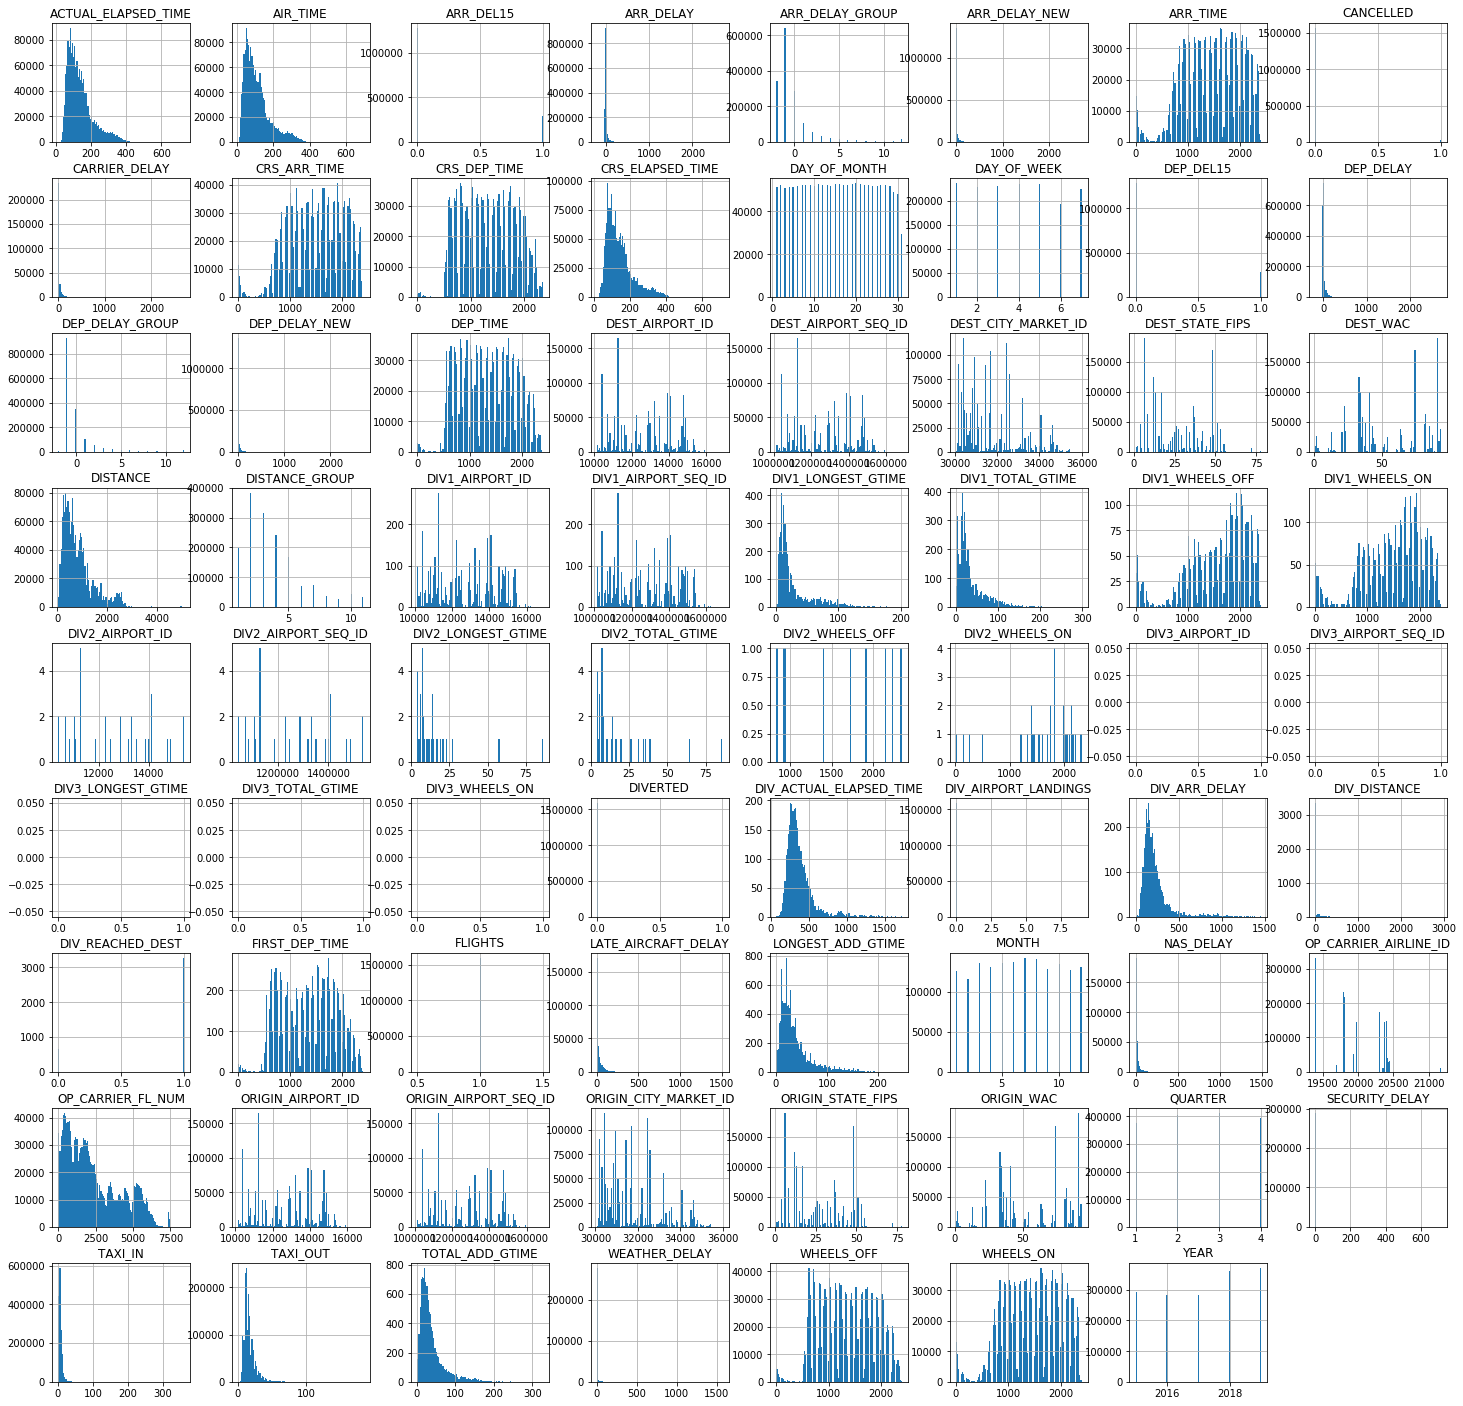

In [8]:
airlines_eda.hist(figsize=(25,25), bins=110)

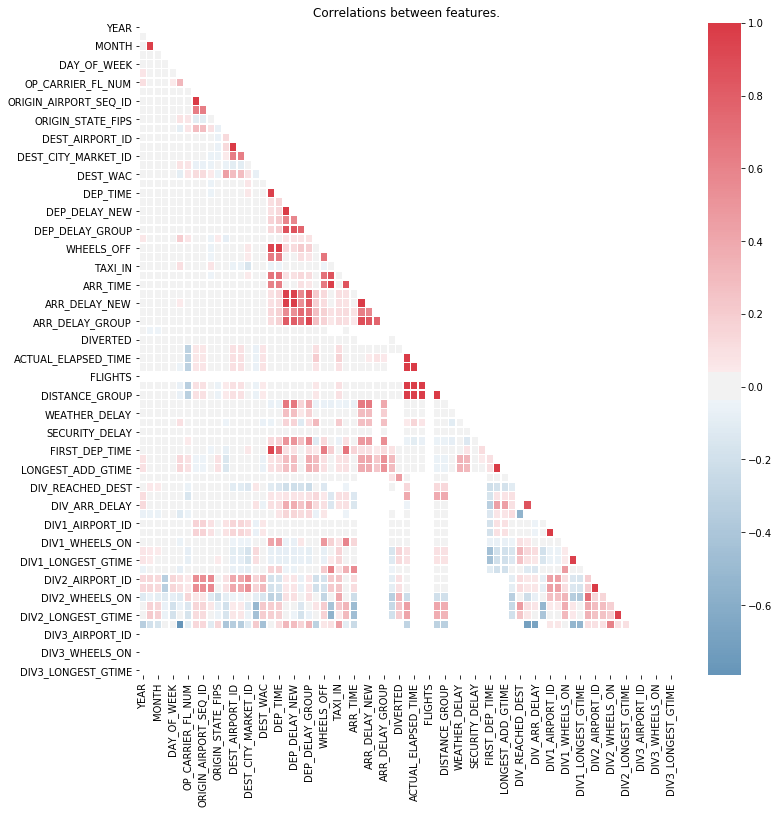

In [9]:
##Correlation Matrix
air_corr = airlines_eda.corr()
fig, ax = plt.subplots(figsize=(12, 12))
mask = np.zeros_like(air_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sn.diverging_palette(240, 10, as_cmap=True)
sn.heatmap(air_corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
display(plt.show())

##Weather Exploration

In [11]:
#Sample Dataset
#weather = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/*.parquet")
#Full Dataset
weather_2015 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/*.parquet")
weather_2016 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2016a.parquet/*.parquet")
weather_2017 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2017a.parquet/*.parquet")
weather_2018 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2018a.parquet/*.parquet")
weather_2019 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2019a.parquet/*.parquet")
weather = weather_2015.union(weather_2016).union(weather_2017).union(weather_2018).union(weather_2019)

In [12]:
weather_eda, weather_other = weather.repartition(20,'DATE').randomSplit([0.05,0.95], seed=4)
#weather_eda = weather_eda.toPandas()

In [13]:
#weather_eda.hist(figsize=(5,5), bins=10)

##Stations Exploration

In [15]:
stations = spark.read.option("header", "true").csv("dbfs:/mnt/mids-w261/data/DEMO8/gsod/stations.csv.gz")

##Airlines Clean-up

In [17]:
#airlines['DEP_DEL15'] = airlines['DEP_DEL15'].fillna(0)
airlines.fillna(0, subset=['DEP_DEL15'])
#airlines['DELAY_15'] = airlines.DEP_DEL15
airlines = airlines.withColumn("DELAY_15", f.col("DEP_DEL15"))

In [18]:
#cancel_index = airlines.loc[airlines['CANCELLED'] == 1].index
#airlines.iloc[cancel_index,-1] = 0
airlines = airlines.withColumn('DELAY_15',when(airlines.CANCELLED == 1, 0))

In [19]:
del_list_time_period = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK']
airlines = airlines.drop(*del_list_time_period)

In [20]:
del_list_origin = ['ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM', 'ORIGIN_WAC']
airlines = airlines.drop(*del_list_origin)

In [21]:
# delete destination related redundant variables
del_list_dest = ['DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC']
airlines = airlines.drop(*del_list_dest)

In [22]:
del_list_dest_perf = ['DEP_DELAY', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK']
airlines = airlines.drop(*del_list_dest_perf)

In [23]:
# delete arrival performance related redundant variables
del_list_arr_perf = ['ARR_DELAY', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK']
airlines = airlines.drop(*del_list_arr_perf)

In [24]:
airlines = airlines.drop('DISTANCE_GROUP')

In [25]:
del_list_div_info = ['DIV4_AIRPORT', 'DIV4_AIRPORT_ID', 'DIV4_AIRPORT_SEQ_ID', 'DIV4_WHEELS_ON', 'DIV4_TOTAL_GTIME', 'DIV4_LONGEST_GTIME', 'DIV4_WHEELS_OFF', 'DIV4_TAIL_NUM', 'DIV5_AIRPORT', 'DIV5_AIRPORT_ID', 'DIV5_AIRPORT_SEQ_ID', 'DIV5_WHEELS_ON', 'DIV5_TOTAL_GTIME', 'DIV5_LONGEST_GTIME', 'DIV5_WHEELS_OFF', 'DIV5_TAIL_NUM']
airlines = airlines.drop(*del_list_div_info)

In [26]:
# delete outcome related variables
del_list_outcome_related = ['DEP_DELAY_NEW', 'ARR_DELAY_NEW']
airlines = airlines.drop(*del_list_outcome_related)

In [27]:
airlines_eda = airlines.toPandas()

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-2542098129690284> in <module> 
 ----> 1 airlines_eda = airlines . toPandas ( ) 

 /databricks/spark/python/pyspark/sql/pandas/conversion.py in toPandas (self) 
 106 # Rename columns to avoid duplicated column names. 
 107 tmp_column_names = [ 'col_{}' . format ( i ) for i in range ( len ( self . columns ) ) ] 
 --> 108 batches = self . toDF ( * tmp_column_names ) . _collect_as_arrow ( ) 
 109 if len ( batches ) > 0 : 
 110 table = pyarrow . Table . from_batches ( batches ) 

 /databricks/spark/python/pyspark/sql/pandas/conversion.py in _collect_as_arrow (self) 
 244 finally : 
 245 # Join serving thread and raise any exceptions from collectAsArrowToPython 
 --> 246 jsocket_auth_server . getResult ( ) 
 247 
 248 # Separate RecordBatches from batch order indices in results 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 126 def deco ( * a , ** kw ) : 
 127 try : 
 --> 128 return f ( * a , ** kw ) 
 129 except py4j . protocol . Py4JJavaError as e : 
 130 converted = convert_exception ( e . java_exception ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 --> 328 format(target_id, ".", name), value)
 329 else : 
 330 raise Py4JError(

 Py4JJavaError : An error occurred while calling o22268.getResult.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:431)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:98)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:94)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:380)
	at py4j.Gateway.invoke(Gateway.java:295)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:251)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Total size of serialized results of 47 tasks (4.1 GiB) is bigger than spark.driver.maxResultSize (4.0 GiB)
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2476)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2425)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2424)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2424)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1129)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1129)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1129)
	at org.apache.spark.

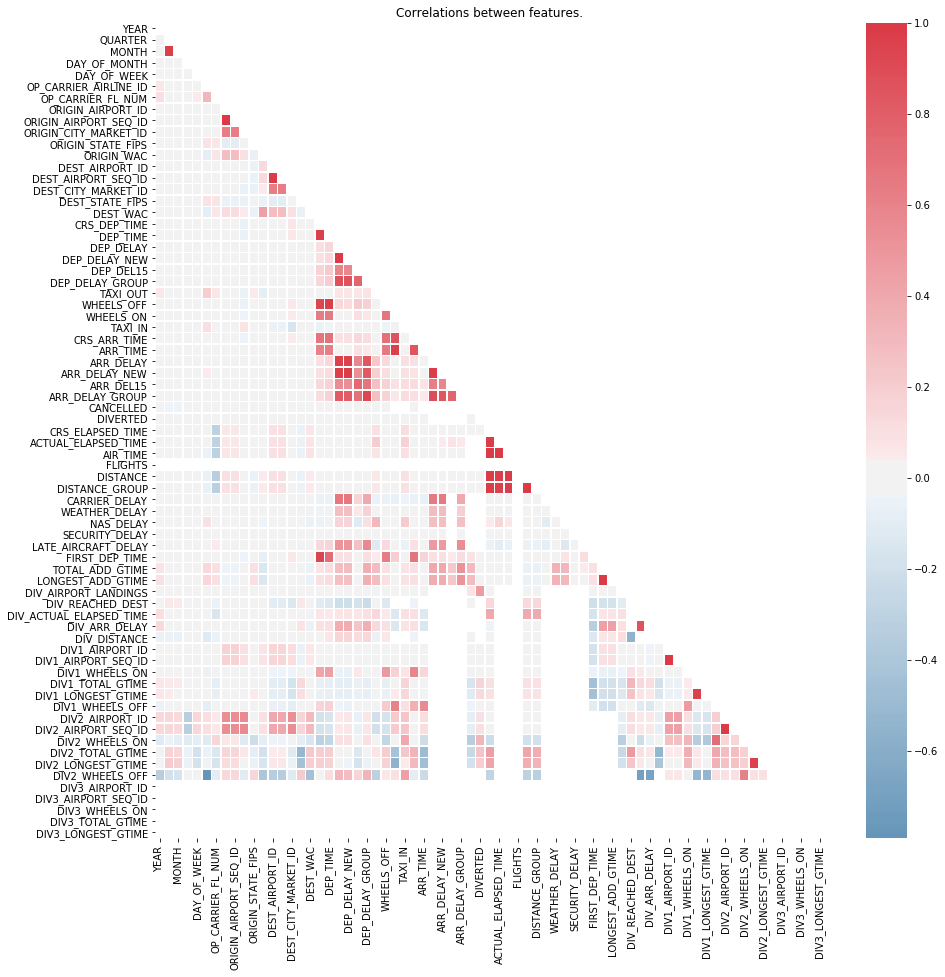

In [28]:
## New Correlation Matrix
air_corr = airlines_eda.corr()
fig, ax = plt.subplots(figsize=(15, 15))
mask = np.zeros_like(air_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sn.diverging_palette(240, 10, as_cmap=True)
sn.heatmap(air_corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
display(plt.show())

In [29]:
airlines = airlines.withColumn("ADJ_DEP_TIME", col('DEP_TIME'))
airlines = airlines.filter(length(airlines.ADJ_DEP_TIME) != 0)
airlines = airlines.filter(airlines.CANCELLED == 0.0)
airlines = airlines.withColumn('DEP_HOUR', when(length(col('ADJ_DEP_TIME')) == 3, airlines.ADJ_DEP_TIME.substr(1,1)).otherwise(airlines.ADJ_DEP_TIME.substr(1,2)))

In [30]:
airlines = airlines.withColumn('CANCELLATION_CODE', when(col('CANCELLATION_CODE') != "", col('CANCELLATION_CODE')).otherwise(0))
airlines = airlines.withColumn('DIV_DISTANCE', when(col('DIV_DISTANCE') != "", col('DIV_DISTANCE')).otherwise(0))
airlines = airlines.withColumn('DIV1_WHEELS_OFF', when(col('DIV1_WHEELS_OFF') != "", col('DIV1_WHEELS_OFF')).otherwise(0))
airlines = airlines.withColumn('DIV1_AIRPORT', when(col('DIV1_AIRPORT') != "", col('DIV1_AIRPORT')).otherwise(0))
airlines = airlines.withColumn('DIV2_WHEELS_OFF', when(col('DIV2_WHEELS_OFF') != "", col('DIV2_WHEELS_OFF')).otherwise(0))
airlines = airlines.withColumn('DIV2_AIRPORT', when(col('DIV2_AIRPORT') != "", col('DIV2_AIRPORT')).otherwise(0))
airlines = airlines.withColumn('DIV3_WHEELS_OFF', when(col('DIV3_WHEELS_OFF') != "", col('DIV3_WHEELS_OFF')).otherwise(0))
airlines = airlines.withColumn('DIV3_AIRPORT', when(col('DIV3_AIRPORT') != "", col('DIV3_AIRPORT')).otherwise(0))
airlines = airlines.withColumn('DIV1_TAIL_NUM', when(col('DIV1_TAIL_NUM') != "", col('DIV1_TAIL_NUM')).otherwise(0))
airlines = airlines.withColumn('DIV2_TAIL_NUM', when(col('DIV2_TAIL_NUM') != "", col('DIV2_TAIL_NUM')).otherwise(0))
airlines = airlines.withColumn('DIV3_TAIL_NUM', when(col('DIV3_TAIL_NUM') != "", col('DIV3_TAIL_NUM')).otherwise(0))
airlines = airlines.fillna(0)

In [31]:
airlines.drop('DIV1_TAIL_NUM')
airlines.drop('DIV2_TAIL_NUM')
airlines.drop('DIV3_TAIL_NUM')

Out[192]: DataFrame[FL_DATE: string, OP_UNIQUE_CARRIER: string, OP_CARRIER_AIRLINE_ID: int, OP_CARRIER: string, TAIL_NUM: string, OP_CARRIER_FL_NUM: int, ORIGIN: string, DEST: string, CRS_DEP_TIME: int, DEP_TIME: int, TAXI_OUT: double, WHEELS_OFF: int, WHEELS_ON: int, TAXI_IN: double, CRS_ARR_TIME: int, ARR_TIME: int, CANCELLED: double, CANCELLATION_CODE: string, DIVERTED: double, CRS_ELAPSED_TIME: double, ACTUAL_ELAPSED_TIME: double, AIR_TIME: double, FLIGHTS: double, DISTANCE: double, CARRIER_DELAY: double, WEATHER_DELAY: double, NAS_DELAY: double, SECURITY_DELAY: double, LATE_AIRCRAFT_DELAY: double, FIRST_DEP_TIME: int, TOTAL_ADD_GTIME: double, LONGEST_ADD_GTIME: double, DIV_AIRPORT_LANDINGS: int, DIV_REACHED_DEST: double, DIV_ACTUAL_ELAPSED_TIME: double, DIV_ARR_DELAY: double, DIV_DISTANCE: double, DIV1_AIRPORT: string, DIV1_AIRPORT_ID: int, DIV1_AIRPORT_SEQ_ID: int, DIV1_WHEELS_ON: int, DIV1_TOTAL_GTIME: double, DIV1_LONGEST_GTIME: double, DIV1_WHEELS_OFF: int, DIV1_TAIL_NUM: string, DIV2_AIRPORT: string, DIV2_AIRPORT_ID: int, DIV2_AIRPORT_SEQ_ID: int, DIV2_WHEELS_ON: int, DIV2_TOTAL_GTIME: double, DIV2_LONGEST_GTIME: double, DIV2_WHEELS_OFF: int, DIV2_TAIL_NUM: string, DIV3_AIRPORT: string, DIV3_AIRPORT_ID: int, DIV3_AIRPORT_SEQ_ID: int, DIV3_WHEELS_ON: int, DIV3_TOTAL_GTIME: double, DIV3_LONGEST_GTIME: double, DIV3_WHEELS_OFF: string, DELAY_15: int, ADJ_DEP_TIME: int, DEP_HOUR: string]

In [32]:
#String Index and OneHot Encoding for the label columns
label_columns_air = ('ORIGIN', 'DEP_HOUR', 'OP_UNIQUE_CARRIER', 'DEST', 'CANCELLATION_CODE', 'DIV1_AIRPORT')
stringIndexer_air = [StringIndexer(inputCol=col, outputCol=col+"_INDEX", handleInvalid = "keep") for col in label_columns_air]
encoder_air = [OneHotEncoder(inputCol=col.getOutputCol(), outputCol="{0}_encoded".format(col.getOutputCol())) for col in stringIndexer_air]

In [33]:
pipe_stages_air = []
pipe_stages_air.extend(stringIndexer_air)
pipe_stages_air.extend(encoder_air)

In [34]:
pipeline_air = Pipeline(stages=pipe_stages_air)
airlines = pipeline_air.fit(airlines).transform(airlines)

In [35]:
# Standardize continuous variables
air_cont = ['CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'DIV_ACTUAL_ELAPSED_TIME', 'DIV_ARR_DELAY', 'DIV_DISTANCE']
#Standard Scaler
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec", handleInvalid='keep') for col in air_cont]
scalers = [StandardScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in air_cont]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel_airlines = pipeline.fit(airlines)
scaledData_airlines = scalerModel_airlines.transform(airlines)

In [36]:
## Weather data work
weather = weather.filter(length(trim(weather.CALL_SIGN)) < 5)
weather = weather.withColumn("ORIGIN", trim(col('CALL_SIGN')).substr(2,3))

In [37]:
cols_to_delete = ['GA4','MW2','OD2','GN1','GG3','AU5','HL1','OB1','AT8','AW7','AZ1','CH1','GK1','IB1','CT1','CN2','MW5','AO1','CR1','CF2','GM1','AY2','MW6',
                 'AL2','AL3','AX5','IB2','CV3','GH1','KF1','CU2','CT3','SA1','GO1','CG3','AL1','AW6','MW4','AX6','CV1','ME1','CN1','UA1','GD5','UG2','GJ1','MV1',
                 'GA5','CT2','CG2','CO1','MW3','AY1','CU3','GA6','GL1','IA1','GG2','OD3','UG1','CB1','CI1','CV2','AZ2','WD1','AA4','IA2','CF3','CU1','CN4','CG1',
                 'CF1','GG1','MV2','CW1','GG4','CN3','QUALITY_CONTROL']
weather = weather.drop(*cols_to_delete)

In [38]:
cols_to_delete1 = ['AB1','AD1','AE1','AK1','AH1','AH2','AH3','AH4','AH5','AH6','AI1','AI2','AI3','AI4',"AI5",'AI6','AM1','AU1','AU2','AU3','AU4',"AW1",'AW2','AW3','AW4','AW5','KC1','KC2','KD1',
                   'KD2','KE1','KG1','KG2','GA1','GA2','GA3','GE1','GF1','MH1','MG1','MK1','MW1','OD1']
weather = weather.drop(*cols_to_delete1)

In [39]:
# Add 2 hours in weather data because we want the predict the delay 2 hours before departure. Add DEP_HOUR and DEP_DATE columns in weather to represent the departure time
weather = weather.withColumn('DEP_HOUR', hour(weather.DATE + f.expr('INTERVAL 2 HOURS')))
weather = weather.withColumn('FL_DATE', to_date(weather.DATE + f.expr('INTERVAL 2 HOURS')))

In [40]:
weather = weather.withColumn('AA', f.concat('AA1', 'AA2', 'AA3'))
weather = weather.withColumn('AT', f.concat('AT1', 'AT2', 'AT3', 'AT4', 'AT5', 'AT6', 'AT7'))
weather = weather.withColumn('AX', f.concat('AX1', 'AX2', 'AX3', 'AX4'))
weather = weather.withColumn('GD', f.concat('GD1', 'GD2', 'GD3', 'GD4'))
weather = weather.withColumn('KA', f.concat('KA1', 'KA2', 'KA3', 'KA4'))
weather = weather.withColumn('KB', f.concat('KB1', 'KB2', 'KB3'))
weather = weather.withColumn('OE', f.concat('OE1', 'OE2', 'OE3'))
weather = weather.withColumn('RH', f.concat('RH1', 'RH2', 'RH3'))

In [41]:
cols_to_delete2 = ['AA1', 'AA2', 'AA3', 'AT1', 'AT2', 'AT3', 'AT4', 'AT5', 'AT6', 'AT7', 'AX1', 'AX2', 'AX3', 'AX4', 'GD1', 'GD2', 'GD3', 'GD4', 
                  'KA1', 'KA2', 'KA3', 'KA4', 'KB1', 'KB2', 'KB3', 'OE1', 'OE2', 'OE3', 'RH1', 'RH2', 'RH3']
weather = weather.drop(*cols_to_delete2)

In [42]:
weather = weather.withColumn('AJ1', split(col('AJ1'), ',').getItem(0))
weather = weather.withColumn('AX', split(col('AX'), ',').getItem(0))
weather = weather.withColumn('GD', split(col('GD'), ',').getItem(0))
weather = weather.withColumn('MF1', split(col('MF1'), ',').getItem(0))
weather = weather.withColumn('OC1', split(col('OC1'), ',').getItem(0))
weather = weather.withColumn('CIG', split(col('CIG'), ',').getItem(0))
weather = weather.withColumn('VIS', split(col('VIS'), ',').getItem(0))

weather = weather.withColumn('AA', split(col('AA'), ',').getItem(1))
weather = weather.withColumn('AN1', split(col('AN1'), ',').getItem(1))
weather = weather.withColumn('AT', split(col('AT'), ',').getItem(1))
weather = weather.withColumn('WA1', split(col('WA1'), ',').getItem(1))

weather = weather.withColumn('RH', split(col('RH'), ',').getItem(2))
weather = weather.withColumn('OE', split(col('OE'), ',').getItem(2))
weather = weather.withColumn('MA1', split(col('MA1'), ',').getItem(2))
weather = weather.withColumn('MD1', split(col('MD1'), ',').getItem(2))
weather = weather.withColumn('KB', split(col('KB'), ',').getItem(2))
weather = weather.withColumn('KA', split(col('KA'), ',').getItem(2))
weather = weather.withColumn('ED1', split(col('ED1'), ',').getItem(2))

weather = weather.withColumn('WND', split(col('WND'), ',').getItem(3))

In [43]:
weather = weather.withColumn('OC1', when(col('OC1') == '', 0).otherwise(col('OC1')))
weather = weather.withColumn('EQD', when(col('EQD') == '', 0).otherwise(col('EQD')))
weather = weather.withColumn('AJ1', when(col('AJ1') == '', 0).otherwise(col('AJ1')))
weather = weather.withColumn('MF1', when(col('MF1') == '', 0).otherwise(col('MF1')))
weather = weather.withColumn('AX', when(col('AX') == '', 0).otherwise(col('AX')))
weather = weather.withColumn('GD', when(col('GD') == '', 0).otherwise(col('GD')))

In [44]:
weather = weather.withColumn('AN1', when((col('AN1') != ""), 'AN1').otherwise(0))
weather = weather.withColumn('WA1', when((col('WA1') != ""), 'WA1').otherwise(0))
weather = weather.withColumn('ED1', when((col('ED1') != ""), 'ED1').otherwise(0))
weather = weather.withColumn('AA', when((col('AA') != ""), 'AA').otherwise(0))
weather = weather.withColumn('AT', when((col('AT') != ""), 'AT').otherwise(0))
weather = weather.withColumn('KA', when((col('KA') != ""), 'KA').otherwise(0))
weather = weather.withColumn('KB', when((col('KB') != ""), 'KB').otherwise(0))
weather = weather.withColumn('OE', when((col('OE') != ""), 'OE').otherwise(0))
weather = weather.withColumn('RH', when((col('RH') != ""), 'RH').otherwise(0))

In [45]:
#NEED TO CONVERT TO STRINGS
weather = weather.withColumn('AA', col('AA').cast("float"))
weather = weather.withColumn('AJ1', col('AJ1').cast("float"))
weather = weather.withColumn('ED1', col('ED1').cast("float"))
weather = weather.withColumn('KA', col('KA').cast("float"))
weather = weather.withColumn('KB', col('KB').cast("float"))
weather = weather.withColumn('MA1', col('MA1').cast("float"))
weather = weather.withColumn('MD1', col('MD1').cast("float"))
weather = weather.withColumn('MF1', col('MF1').cast("float"))
weather = weather.withColumn('OC1', col('OC1').cast("float"))
weather = weather.withColumn('OE', col('OE').cast("float"))
weather = weather.withColumn('RH', col('RH').cast("float"))
weather = weather.withColumn('WA1', col('WA1').cast("float"))

In [46]:
wtr_cont = ['AA','AJ1','ED1','KA','KB','MA1','MD1','MF1','OC1','OE','RH','WA1']

In [47]:
#String Indexers and OneHot Encoding
label_columns_wtr = ('REPORT_TYPE', 'WND', 'CIG', 'VIS', 'TMP', 'DEW', 'SLP', 'EQD', 'AN1', 'AT', 'AX', 'GD')
stringIndexer_wtr = [StringIndexer(inputCol=col, outputCol=col+"_INDEX", handleInvalid = "keep") for col in label_columns_wtr]
encoder_wtr = [OneHotEncoder(inputCol=col.getOutputCol(), outputCol="{0}_encoded".format(col.getOutputCol())) for col in stringIndexer_wtr]

In [48]:
pipe_stages_wtr = []
pipe_stages_wtr.extend(stringIndexer_wtr)
pipe_stages_wtr.extend(encoder_wtr)

In [49]:
pipeline_wtr = Pipeline(stages=pipe_stages_wtr)
weather = pipeline_wtr.fit(weather).transform(weather)

In [50]:
#Standard Scaler
weather = weather.fillna(0)
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec", handleInvalid='keep') for col in wtr_cont]
scalers = [StandardScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in wtr_cont]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel_weather = pipeline.fit(weather)
scaledData_weather = scalerModel_weather.transform(weather)

##Spark Models

In [52]:
data = scaledData_airlines.join(scaledData_weather, on = ['ORIGIN', 'FL_DATE', 'DEP_HOUR'])
data = data.fillna(0)

cols_to_drop = ('FL_DATE', 'OP_CARRIER', 'TAIL_NUM', 'CALL_SIGN', 'DIV3_WHEELS_OFF', 'STATION', 'NAME', 'DIV2_AIRPORT', 'DIV3_AIRPORT', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'DIV_ACTUAL_ELAPSED_TIME', 'DIV_ARR_DELAY', 'DIV_DISTANCE', 'AA', 'AJ1', 'ED1', 'KA', 'KB', 'MA1', 'MD1', 'MF1', 'OC1', 'OE', 'RH', 'WA1')
data.drop(*cols_to_drop)

Out[212]: DataFrame[ORIGIN: string, DEP_HOUR: string, OP_UNIQUE_CARRIER: string, OP_CARRIER_AIRLINE_ID: int, OP_CARRIER_FL_NUM: int, DEST: string, CRS_DEP_TIME: int, DEP_TIME: int, TAXI_OUT: double, WHEELS_OFF: int, WHEELS_ON: int, TAXI_IN: double, CRS_ARR_TIME: int, ARR_TIME: int, CANCELLED: double, CANCELLATION_CODE: string, DIVERTED: double, FLIGHTS: double, FIRST_DEP_TIME: int, TOTAL_ADD_GTIME: double, LONGEST_ADD_GTIME: double, DIV_AIRPORT_LANDINGS: int, DIV_REACHED_DEST: double, DIV1_AIRPORT: string, DIV1_AIRPORT_ID: int, DIV1_AIRPORT_SEQ_ID: int, DIV1_WHEELS_ON: int, DIV1_TOTAL_GTIME: double, DIV1_LONGEST_GTIME: double, DIV1_WHEELS_OFF: int, DIV1_TAIL_NUM: string, DIV2_AIRPORT_ID: int, DIV2_AIRPORT_SEQ_ID: int, DIV2_WHEELS_ON: int, DIV2_TOTAL_GTIME: double, DIV2_LONGEST_GTIME: double, DIV2_WHEELS_OFF: int, DIV2_TAIL_NUM: string, DIV3_AIRPORT_ID: int, DIV3_AIRPORT_SEQ_ID: int, DIV3_WHEELS_ON: int, DIV3_TOTAL_GTIME: double, DIV3_LONGEST_GTIME: double, DIV3_TAIL_NUM: string, DELAY_15: int, ADJ_DEP_TIME: int, ORIGIN_INDEX: double, DEP_HOUR_INDEX: double, OP_UNIQUE_CARRIER_INDEX: double, DEST_INDEX: double, CANCELLATION_CODE_INDEX: double, DIV1_AIRPORT_INDEX: double, ORIGIN_INDEX_encoded: vector, DEP_HOUR_INDEX_encoded: vector, OP_UNIQUE_CARRIER_INDEX_encoded: vector, DEST_INDEX_encoded: vector, CANCELLATION_CODE_INDEX_encoded: vector, DIV1_AIRPORT_INDEX_encoded: vector, CRS_ELAPSED_TIME_vec: vector, ACTUAL_ELAPSED_TIME_vec: vector, AIR_TIME_vec: vector, DISTANCE_vec: vector, CARRIER_DELAY_vec: vector, WEATHER_DELAY_vec: vector, NAS_DELAY_vec: vector, SECURITY_DELAY_vec: vector, LATE_AIRCRAFT_DELAY_vec: vector, DIV_ACTUAL_ELAPSED_TIME_vec: vector, DIV_ARR_DELAY_vec: vector, DIV_DISTANCE_vec: vector, CRS_ELAPSED_TIME_scaled: vector, ACTUAL_ELAPSED_TIME_scaled: vector, AIR_TIME_scaled: vector, DISTANCE_scaled: vector, CARRIER_DELAY_scaled: vector, WEATHER_DELAY_scaled: vector, NAS_DELAY_scaled: vector, SECURITY_DELAY_scaled: vector, LATE_AIRCRAFT_DELAY_scaled: vector, DIV_ACTUAL_ELAPSED_TIME_scaled: vector, DIV_ARR_DELAY_scaled: vector, DIV_DISTANCE_scaled: vector, DATE: timestamp, SOURCE: smallint, LATITUDE: double, LONGITUDE: double, ELEVATION: double, REPORT_TYPE: string, WND: string, CIG: string, VIS: string, TMP: string, DEW: string, SLP: string, REM: string, EQD: string, AN1: string, AT: string, AX: string, GD: string, REPORT_TYPE_INDEX: double, WND_INDEX: double, CIG_INDEX: double, VIS_INDEX: double, TMP_INDEX: double, DEW_INDEX: double, SLP_INDEX: double, EQD_INDEX: double, AN1_INDEX: double, AT_INDEX: double, AX_INDEX: double, GD_INDEX: double, REPORT_TYPE_INDEX_encoded: vector, WND_INDEX_encoded: vector, CIG_INDEX_encoded: vector, VIS_INDEX_encoded: vector, TMP_INDEX_encoded: vector, DEW_INDEX_encoded: vector, SLP_INDEX_encoded: vector, EQD_INDEX_encoded: vector, AN1_INDEX_encoded: vector, AT_INDEX_encoded: vector, AX_INDEX_encoded: vector, GD_INDEX_encoded: vector, AA_vec: vector, AJ1_vec: vector, ED1_vec: vector, KA_vec: vector, KB_vec: vector, MA1_vec: vector, MD1_vec: vector, MF1_vec: vector, OC1_vec: vector, OE_vec: vector, RH_vec: vector, WA1_vec: vector, AA_scaled: vector, AJ1_scaled: vector, ED1_scaled: vector, KA_scaled: vector, KB_scaled: vector, MA1_scaled: vector, MD1_scaled: vector, MF1_scaled: vector, OC1_scaled: vector, OE_scaled: vector, RH_scaled: vector, WA1_scaled: vector]

In [53]:
#sampleData, restData = data.randomSplit([0.0005, 0.9995], seed = 42)

In [54]:
label_columns = ('ORIGIN', 'DEP_HOUR', 'OP_UNIQUE_CARRIER', 'DEST', 'CANCELLATION_CODE', 'DIV1_AIRPORT', 'REPORT_TYPE', 'WND', 'CIG', 'VIS', 'TMP', 'DEW', 'SLP', 'REM', 'EQD', 'AN1', 'AT', 'AX', 'GD',  'STATION',  'SOURCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'CALL_SIGN', 'MA1', 'MD1', 'OC1', 'AJ1', 'MF1', 'WA1', 'ED1', 'AA', 'KA', 'KB', 'OE',  'RH','FL_DATE',
 'OP_CARRIER_AIRLINE_ID',  'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'CANCELLED', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME', 'DIV_AIRPORT_LANDINGS', 'DIV_REACHED_DEST', 'DIV_ACTUAL_ELAPSED_TIME', 'DIV_ARR_DELAY', 'DIV_DISTANCE', 'DIV1_AIRPORT_ID', 'DIV1_AIRPORT_SEQ_ID', 'DIV1_WHEELS_ON', 'DIV1_TOTAL_GTIME', 'DIV1_LONGEST_GTIME', 'DIV1_WHEELS_OFF', 'DIV1_TAIL_NUM', 'DIV2_AIRPORT', 'DIV2_AIRPORT_ID', 'DIV2_AIRPORT_SEQ_ID', 'DIV2_WHEELS_ON', 'DIV2_TOTAL_GTIME', 'DIV2_LONGEST_GTIME', 'DIV2_WHEELS_OFF', 'DIV2_TAIL_NUM', 'DIV3_AIRPORT', 'DIV3_AIRPORT_ID', 'DIV3_AIRPORT_SEQ_ID', 'DIV3_WHEELS_ON', 'DIV3_TOTAL_GTIME', 'DIV3_LONGEST_GTIME', 'DIV3_WHEELS_OFF', 'DIV3_TAIL_NUM', 'ADJ_DEP_TIME',  'AA_vec', 'AJ1_vec', 'ED1_vec', 'KA_vec', 'KB_vec', 'MA1_vec', 'MD1_vec', 'MF1_vec', 'OC1_vec', 'OE_vec', 'RH_vec', 'WA1_vec',  'REPORT_TYPE_INDEX', 'WND_INDEX', 'CIG_INDEX', 'VIS_INDEX', 'TMP_INDEX', 'DEW_INDEX', 'SLP_INDEX', 'EQD_INDEX', 'AN1_INDEX', 'AT_INDEX', 'AX_INDEX', 'GD_INDEX', 'ORIGIN_INDEX', 'DEP_HOUR_INDEX', 'OP_UNIQUE_CARRIER_INDEX', 'DEST_INDEX', 'CANCELLATION_CODE_INDEX', 'DIV1_AIRPORT_INDEX', 'CRS_ELAPSED_TIME_vec', 'ACTUAL_ELAPSED_TIME_vec', 'AIR_TIME_vec', 'DISTANCE_vec', 'CARRIER_DELAY_vec', 'WEATHER_DELAY_vec', 'NAS_DELAY_vec', 'SECURITY_DELAY_vec', 'LATE_AIRCRAFT_DELAY_vec', 'DIV_ACTUAL_ELAPSED_TIME_vec', 'DIV_ARR_DELAY_vec', 'DIV_DISTANCE_vec')
feature_columns = data.columns
feature_columns.remove('DELAY_15')
feature_columns.remove('DATE')
feature_cols = [x for x in feature_columns if x not in label_columns]

#Index each label
#stringIndex = [StringIndexer(inputCol=col, outputCol=col+"_INDEX", handleInvalid = "keep").fit(sampleData).transform(sampleData) for col in label_columns]
#stringIndexer = [StringIndexer(inputCol=col, outputCol=col+"_INDEX", handleInvalid = "keep") for col in label_columns]
#encoder = [OneHotEncoder(inputCol=col.getOutputCol(), outputCol="{0}_encoded".format(col.getOutputCol())) for col in stringIndexer]

In [55]:
#Vector transforms
featureAssembler = VectorAssembler(inputCols=feature_cols, outputCol= "features", handleInvalid = "keep")
#Automatically categorize variables buckets = 10 for now
#featureVectorizer = VectorIndexer(inputCol="feature_vec", outputCol="features", handleInvalid = "keep", maxCategories=10)
#Splits for training, test and holdout
trainingData, testData, holdoutData = data.randomSplit([0.6, 0.2, 0.2], seed = 42)

##Logistic Regression

In [57]:
lr = LogisticRegression(featuresCol = "features", labelCol = "DELAY_15", maxIter=10, regParam=0.3, elasticNetParam=0.8)
pipe_stages_lr = []
pipe_stages_lr.extend([featureAssembler])
#pipe_stages_lr.extend([featureVectorizer])
pipe_stages_lr.extend([lr])

pipeline_lr = Pipeline(stages=pipe_stages_lr)
model_lr = pipeline_lr.fit(trainingData)

In [58]:
predictions_lr = model_lr.transform(testData)
predictions_lr.select("prediction", "DELAY_15", "features").show(5)

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-887545360131045> in <module> 
 1 predictions_lr = model_lr . transform ( testData ) 
 ----> 2 predictions_lr . select ( "prediction" , "DELAY_15" , "features" ) . show ( 5 ) 

 /databricks/spark/python/pyspark/sql/dataframe.py in show (self, n, truncate, vertical) 
 439 """
 440 if isinstance ( truncate , bool ) and truncate : 
 --> 441 print ( self . _jdf . showString ( n , 20 , vertical ) ) 
 442 else : 
 443 print ( self . _jdf . showString ( n , int ( truncate ) , vertical ) ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 126 def deco ( * a , ** kw ) : 
 127 try : 
 --> 128 return f ( * a , ** kw ) 
 129 except py4j . protocol . Py4JJavaError as e : 
 130 converted = convert_exception ( e . java_exception ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 --> 328 format(target_id, ".", name), value)
 329 else : 
 330 raise Py4JError(

 Py4JJavaError : An error occurred while calling o27518.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 536259.0 failed 4 times, most recent failure: Lost task 0.3 in stage 536259.0 (TID 8806829, 10.95.227.58, executor 4): org.apache.spark.SparkException: Failed to execute user defined function(ProbabilisticClassificationModel$$Lambda$6776/582002152: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage13.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:731)
	at org.apache.spark.sql.execution.collect.UnsafeRowBatchUtils$.encodeUnsafeRows(UnsafeRowBatchUtils.scala:80)
	at org.apache.spark.sql.execution.collect.Collector.$anonfun$processFunc$1(Collector.scala:187)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.doRunTask(Task.scala:144)
	at org.apache.spark.scheduler.Task.run(Task.scala:117)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$9(Executor.scala:639)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1559)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:642)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 352792, y.size = 124492
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:115)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1(LogisticRegression.scala:998)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1$adapted(LogisticRegression.scala:997)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1141)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:927)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel.$anonfun$transform$2(Pr

##Decision Tree Classifier

In [60]:
dt = DecisionTreeClassifier(labelCol="DELAY_15", featuresCol="features")
#Assemble the stages into a singular list
pipe_stages_dt = []
pipe_stages_dt.extend([featureAssembler])
#pipe_stages_dt.extend([featureVectorizer])
pipe_stages_dt.extend([dt])

pipeline_dt = Pipeline(stages=pipe_stages_dt)
model_dt = pipeline_dt.fit(trainingData)

predictions_dt = model_dt.transform(testData)
predictions_dt.select("prediction", "DELAY_15", "features").show(5)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2542098129690311> in <module> 
 7 
 8 pipeline_dt = Pipeline ( stages = pipe_stages_dt ) 
 ----> 9 model_dt = pipeline_dt . fit ( trainData ) 
 10 
 11 predictions_dt = model_dt . transform ( testData ) 

 NameError : name 'trainData' is not defined

In [61]:
# Select (prediction, true label) and compute test error
evaluator_dt = MulticlassClassificationEvaluator(
    labelCol="DELAY_15", predictionCol="prediction", metricName="accuracy")
accuracy_dt = evaluator_dt.evaluate(predictions_dt)
print("Test Error = %g " % (1.0 - accuracy_dt))

treeModel_dt = model.stages[2]
print(treeModel)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-887545360131046> in <module> 
 5 print ( "Test Error = %g " % ( 1.0 - accuracy_dt ) ) 
 6 
 ----> 7 treeModel_dt = model . stages [ 2 ] 
 8 print ( treeModel ) 

 NameError : name 'model' is not defined

##Random Forest Classifier

In [63]:
rf = RandomForestClassifier(labelCol="DELAY_15", featuresCol="features", numTrees=10)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel")
#Assemble the stages into a singular list
pipe_stages_rf = []
pipe_stages_rf.extend([featureAssembler])
#pipe_stages_rf.extend([featureVectorizer])
pipe_stages_rf.extend([rf])
pipe_stages_rf.extend([labelConverter])

pipeline_rf = Pipeline(stages=pipe_stages_rf)
model_rf = pipeline_rf.fit(trainingData)


predictions_rf = model_rf.transform(testData)
predictions_rf.select("predictedLabel", "DELAY_15", "features").show(5)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2542098129690313> in <module> 
 9 
 10 pipeline_rf = Pipeline ( stages = pipe_stages_rf ) 
 ---> 11 model_rf = pipeline_rf . fit ( trainData ) 
 12 
 13 

 NameError : name 'trainData' is not defined

In [64]:
# Select (prediction, true label) and compute test error
evaluator_rf = MulticlassClassificationEvaluator(
    labelCol="DELAY_15", predictionCol="prediction", metricName="accuracy")
accuracy_rf = evaluator_rf.evaluate(predictions_rf)
print("Test Error = %g" % (1.0 - accuracy_rf))

rfModel = model_rf.stages[2]
print(rfModel)  # summary only

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-887545360131047> in <module> 
 2 evaluator_rf = MulticlassClassificationEvaluator(
 3 labelCol="DELAY_15", predictionCol="prediction", metricName="accuracy")
 ----> 4 accuracy_rf = evaluator_rf . evaluate ( predictions_rf ) 
 5 print ( "Test Error = %g" % ( 1.0 - accuracy_rf ) ) 
 6 

 NameError : name 'predictions_rf' is not defined

##Gradient Boosted Trees

In [66]:
gbt = GBTClassifier(labelCol="DELAY_15", featuresCol="features", maxIter=10)

pipe_stages_gbt = []
pipe_stages_gbt.extend([featureAssembler])
#pipe_stages_gbt.extend([featureVectorizer])
pipe_stages_gbt.extend([gbt])


pipeline_gbt = Pipeline(stages=pipe_stages_gbt)
model_gbt = pipeline_gbt.fit(trainData)


predictions_gbt = model_gbt.transform(testData)
predictions_gbt.select("prediction", "DELAY_15", "features").show(5)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2542098129690315> in <module> 
 8 
 9 pipeline_gbt = Pipeline ( stages = pipe_stages_gbt ) 
 ---> 10 model_gbt = pipeline_gbt . fit ( trainData ) 
 11 
 12 

 NameError : name 'trainData' is not defined

In [67]:
# Select (prediction, true label) and compute test error
evaluator_gbt = MulticlassClassificationEvaluator(
    labelCol="DELAY_15", predictionCol="prediction", metricName="accuracy")
accuracy_gbt = evaluator_gbt.evaluate(predictions_gbt)
print("Test Error = %g" % (1.0 - accuracy))

gbtModel = model.stages[2]
print(gbtModel)  # summary only

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2542098129691718> in <module> 
 2 evaluator_gbt = MulticlassClassificationEvaluator(
 3 labelCol="DELAY_15", predictionCol="prediction", metricName="accuracy")
 ----> 4 accuracy_gbt = evaluator_gbt . evaluate ( predictions_gbt ) 
 5 print ( "Test Error = %g" % ( 1.0 - accuracy ) ) 
 6 

 NameError : name 'predictions_gbt' is not defined